# Clustering via Gausian Mixtures

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

file_path_PCA = "../../reduced_data/joueurs_ligue1_PCA_custom_GK.csv"
file_path_tSNE = "../../reduced_data/joueurs_ligue1_tSNE_custom_GK.csv"
file_path_ISOMAP = "../../reduced_data/joueurs_ligue1_ISOMap_raw.csv"
file_path_UMAP = "../../reduced_data/joueurs_ligue1_2024_2025_clean_per90_umap3d_best_embedding.csv"

data_PCA= pd.read_csv(file_path_PCA, encoding="utf-8")
data_tSNE = pd.read_csv(file_path_tSNE, encoding="utf-8")
data_ISOMAP = pd.read_csv(file_path_ISOMAP, encoding="utf-8")
data_UMAP = pd.read_csv(file_path_UMAP, encoding="utf-8")
print(data_UMAP.head(1))

     player_name  equipe positions   age player_id player_country_code  \
0  Jordan Lefort  Angers        DF  30.0  c3e4ecbb                 FRA   

      UMAP_1    UMAP_2    UMAP_3  
0  14.566432  9.810942  4.336471  


## Data Preparation : standardisation + columns removal

In [47]:
X_PCA = data_PCA.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_tSNE = data_tSNE.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_ISOMAP = data_ISOMAP.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_UMAP = data_UMAP.drop(columns=['player_name', 'equipe', 'positions','player_id','player_country_code', 'age']).copy()

scaler = StandardScaler()
X_PCA = scaler.fit_transform(X_PCA) 
X_tSNE = scaler.fit_transform(X_tSNE)
X_ISOMAP = scaler.fit_transform(X_ISOMAP) 
X_UMAP = scaler.fit_transform(X_UMAP) 
print(X_UMAP[1])

[ 0.07147241 -0.32309249  1.04432427]


## GridSearch Analysis

In [24]:
def gmm_gridsearch(X, n_components_range=range(2, 8), cov_types=['full','tied','diag','spherical'], random_state=42, verbose=True):
    results = []

    for n in n_components_range:
        for cov in cov_types:
            gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=random_state)
            gmm.fit(X)
            labels = gmm.predict(X)

            bic = gmm.bic(X)
            aic = gmm.aic(X)
            #resposabilites = gmm.predict_proba(X)
            convergence = gmm.converged_

            try:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            except Exception as e:
                sil_score = np.nan
                db_score = np.nan
                ch_score = np.nan
            results.append({
                'n_components': n,
                'covariance_type': cov,
                'BIC': bic,
                'AIC': aic,
                'silhouette_score': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score,
                #'resposabilites': resposabilites,
                'converged': convergence
            })

    results_df = pd.DataFrame(results)

    metrics = ['BIC', 'AIC', 'silhouette_score', 'davies_bouldin', 'calinski_harabasz']
    pivot_df = results_df.pivot(index='n_components', columns='covariance_type')[metrics]

    flat_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
    flat_df.columns = [f"{cov}_{metric}" for cov, metric in flat_df.columns]

    # Classements sur chaque indicateur
    rank_df = pd.DataFrame(index=flat_df.index)

    for col in flat_df.columns:
        metric = col.split("_", 1)[1]
        if metric in ['BIC', 'AIC', 'davies_bouldin']:
            rank_df[col] = flat_df[col].rank(method='min', ascending=True)
        else:
            rank_df[col] = flat_df[col].rank(method='min', ascending=False)

    # Moyenne qualité de modélisation (AIC + BIC)
    model_cols = [col for col in rank_df.columns if 'AIC' in col or 'BIC' in col]
    rank_df['mean_model_score'] = rank_df[model_cols].mean(axis=1)

    # Moyenne qualité de clustering (silhouette + db + ch)
    cluster_cols = [col for col in rank_df.columns if any(m in col for m in ['silhouette', 'davies', 'calinski'])]
    rank_df['mean_cluster_score'] = rank_df[cluster_cols].mean(axis=1)

    # Moyenne par covariance type
    covariance_scores = {}
    for cov in cov_types:
        cov_cols = [col for col in rank_df.columns if col.startswith(cov)]
        covariance_scores[cov] = rank_df[cov_cols].mean().mean()  # moyenne sur toutes les lignes

    covariance_df = pd.Series(covariance_scores).sort_values()

    # Affichage
    print("\n📊 Classements et Scores (par combinaison n_components x covariance):")
    cols_to_show = [col for col in flat_df.columns if any(m in col for m in['BIC', 'AIC', 'silhouette', 'davies', 'calinski'])]
    rank_df['mdl_rk'] = rank_df['mean_model_score']
    rank_df['cl_rk'] = rank_df['mean_cluster_score']

    rename_map = {}
    for col in cols_to_show:
        cov, metric = col.split("_", 1)
        short_metric = (metric
                        .replace('silhouette_score', 'sil')
                        .replace('davies_bouldin', 'db')
                        .replace('calinski_harabasz', 'ch')
                        .replace('BIC', 'bic')
                        .replace('AIC', 'aic'))
        rename_map[col] = f"{cov}_{short_metric}"
    
    short_df = flat_df[cols_to_show].rename(columns=rename_map)
    combined_df = pd.concat(
        [short_df, rank_df[['mdl_rk', 'cl_rk']]],
        axis=1
    )
    print(combined_df.round(3))

    print("\n📈 Moyenne des classements par type de covariance (tous n_components confondus):")
    print(covariance_df)

    return results_df, rank_df


gmm_results_PCA = gmm_gridsearch(X_PCA, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_tSNE = gmm_gridsearch(X_tSNE, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_ISOMAP = gmm_gridsearch(X_ISOMAP, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_UMAP = gmm_gridsearch(X_UMAP, n_components_range=range(2,25), cov_types=['full'], random_state=42)


📊 Classements et Scores (par combinaison n_components x covariance):
              full_aic  full_bic  full_ch  full_db  full_sil  mdl_rk   cl_rk
n_components                                                                
2             3756.699  3869.072   72.288    2.035     0.175    14.5  14.333
3             3563.506  3734.003   96.315    1.319     0.270    11.5   4.667
4             3521.589  3750.210  106.386    1.179     0.251    11.5   1.333
5             3470.010  3756.755  105.111    1.213     0.247    11.5   2.667
6             3448.174  3793.043   93.139    1.269     0.219    11.5   4.667
7             3443.702  3846.695   86.404    1.300     0.219    11.5   6.333
8             3411.209  3872.326   81.104    1.383     0.212    10.0   8.667
9             3420.973  3940.214   80.341    1.376     0.218    12.0   8.333
10            3411.529  3988.893   71.737    1.384     0.171    11.5  13.333
11            3383.464  4018.953   69.827    1.660     0.156    10.0  17.000
12    

## Run Gaussian mixtures

In [41]:
def run_gmm(X, data, n_clusters, random_state=42, covariance_type='full', name=""):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)

    df = pd.DataFrame(X, columns=[f'{name}_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)
    
    return df, gmm

X_gmm_PCA_best, gmm_PCA_best = run_gmm(X_PCA, data_PCA, n_clusters = 4, covariance_type = "full", random_state = 42, name = "PCA")
X_gmm_tSNE_best, gmm_tSNE_best = run_gmm(X_tSNE, data_tSNE, n_clusters = 5, covariance_type = "full", random_state = 42, name = "tsne")
X_gmm_ISOMAP_best, gmm_ISOMAP_best = run_gmm(X_ISOMAP, data_ISOMap, n_clusters = 6, covariance_type = "full", random_state = 42, name = "isomap")
X_gmm_UMAP_best, gmm_UMAP_best = run_gmm(X_UMAP, data_UMAP, n_clusters = 5, covariance_type = "full", random_state = 42, name = "UMAP")

## Results Display

============RESULTS EN 2D===============


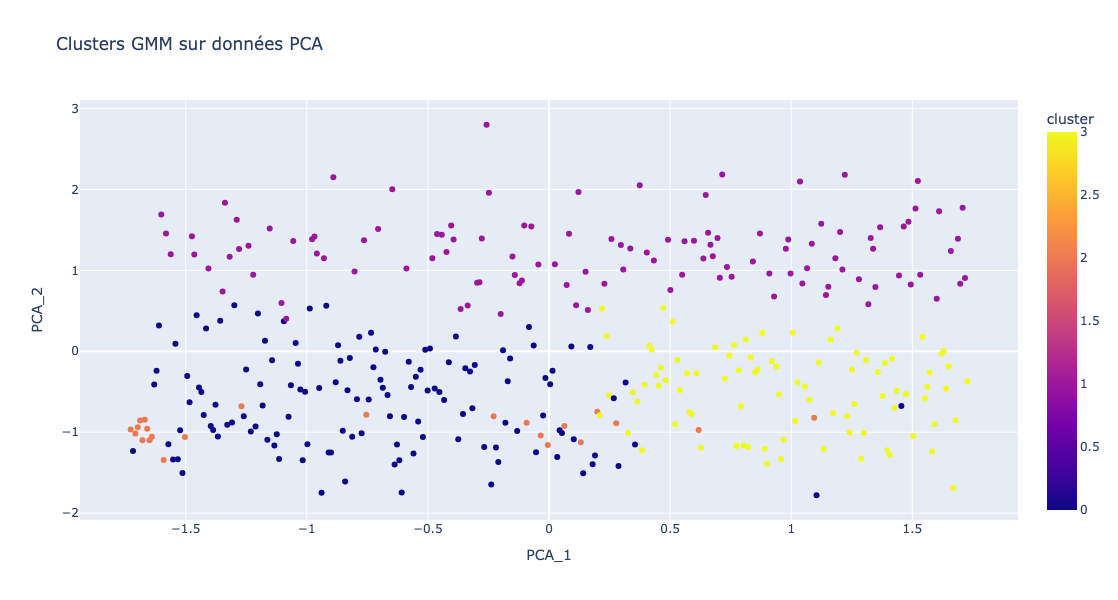

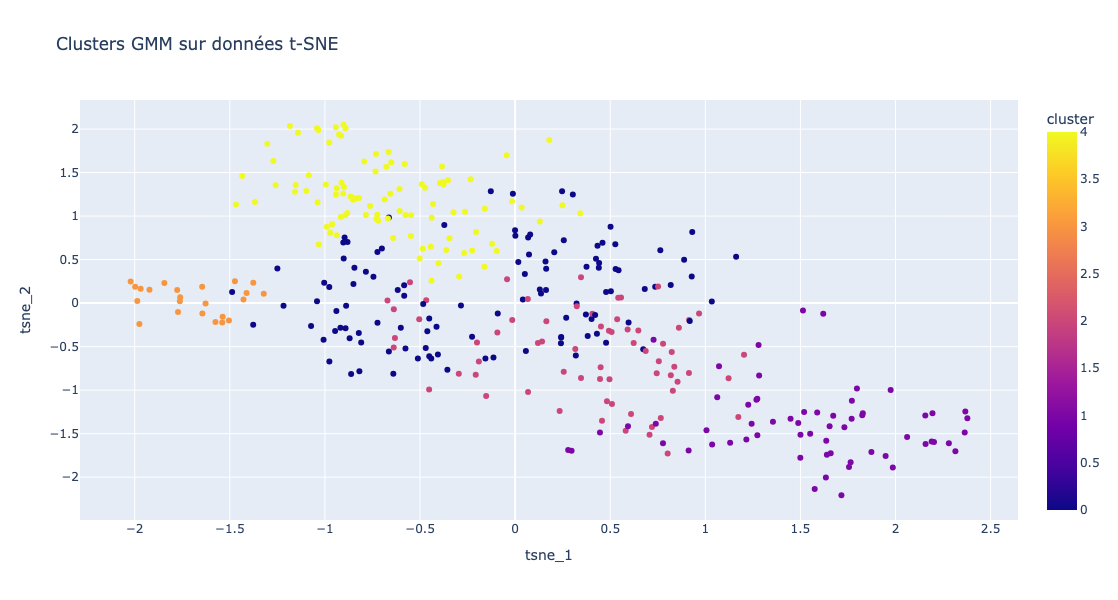

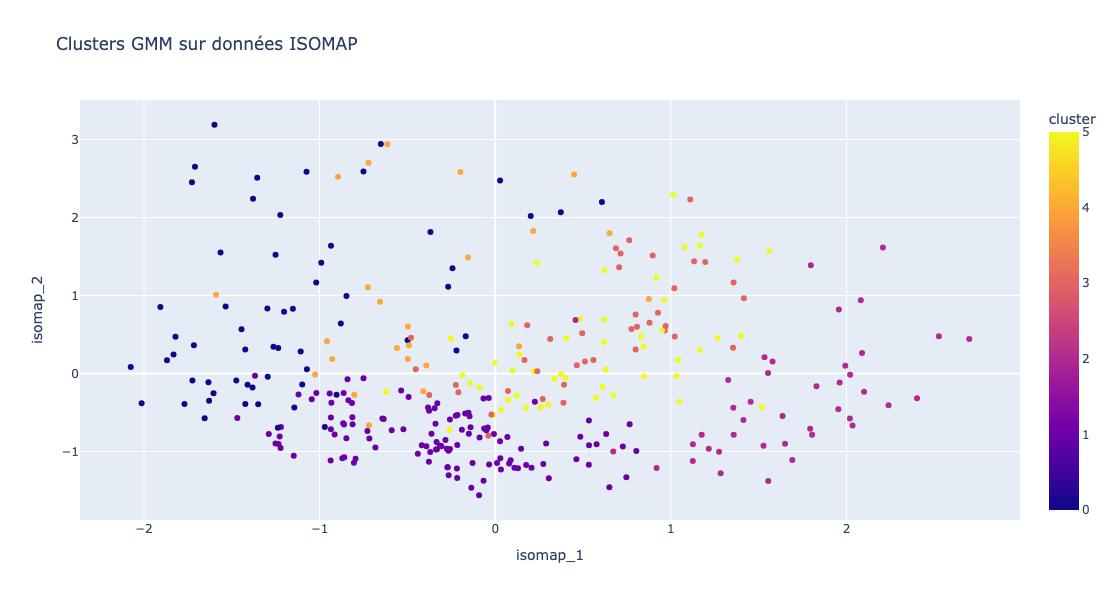

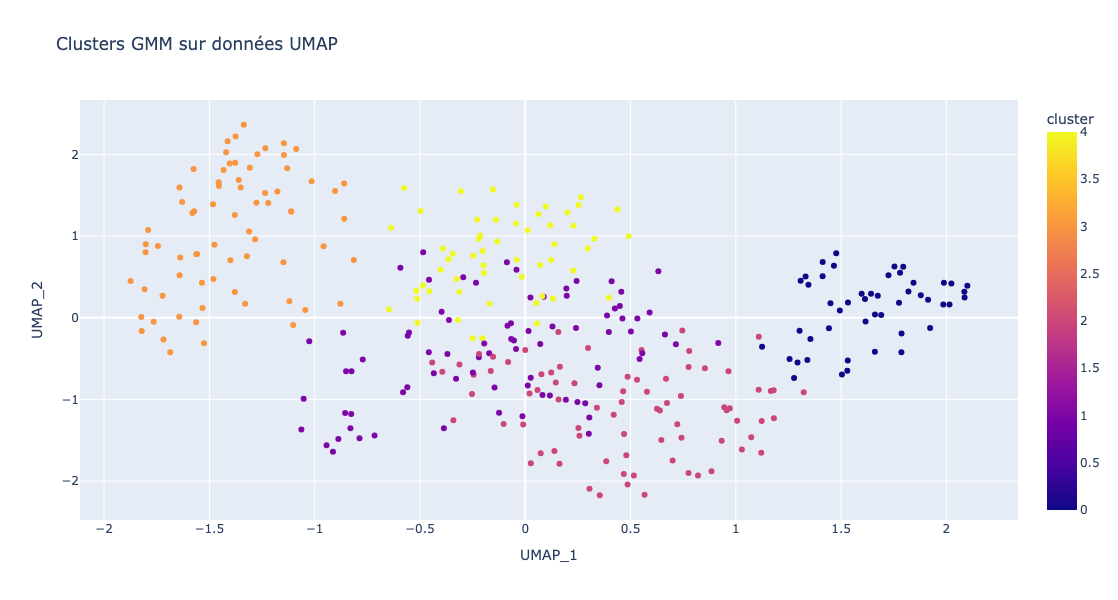

============RESULTS EN 3D===============


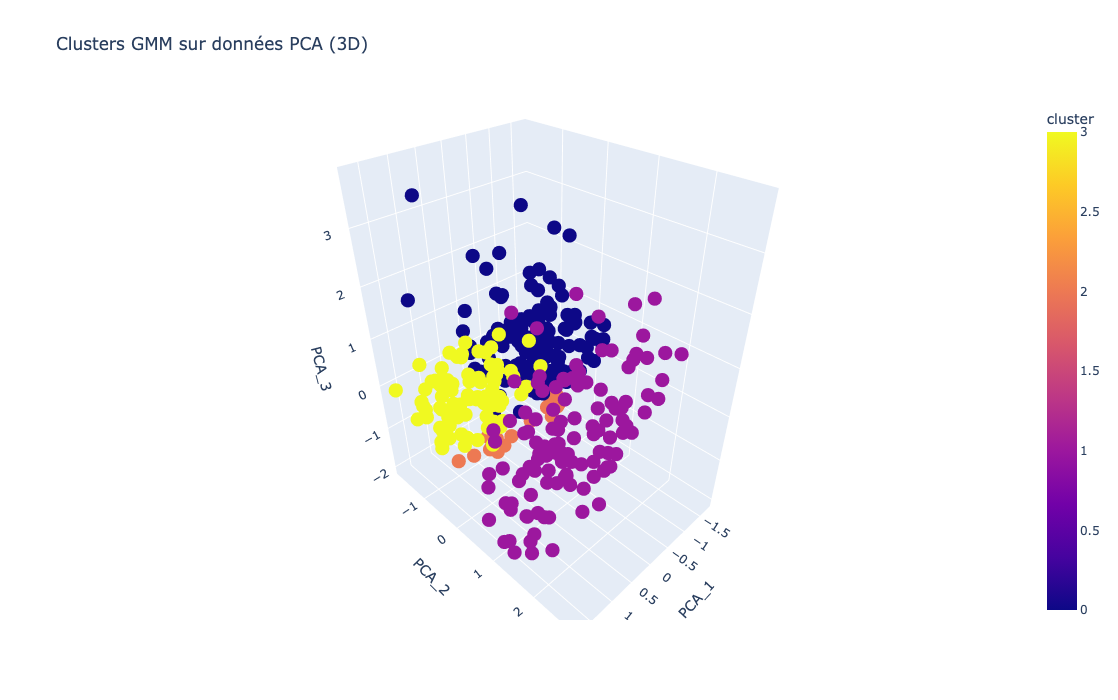

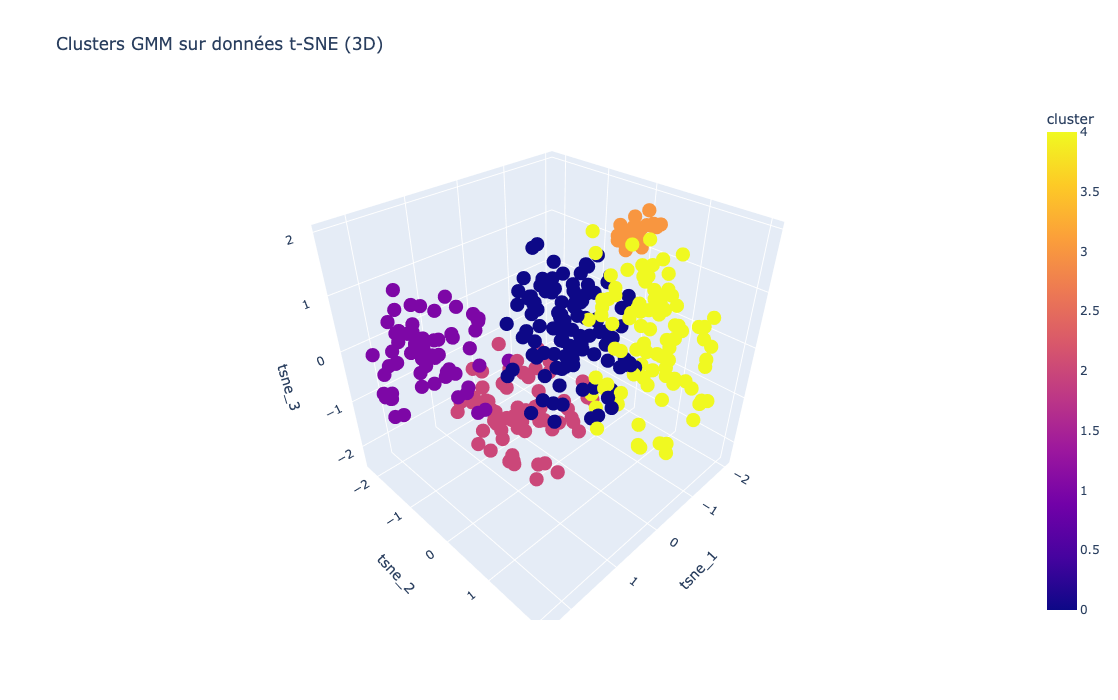

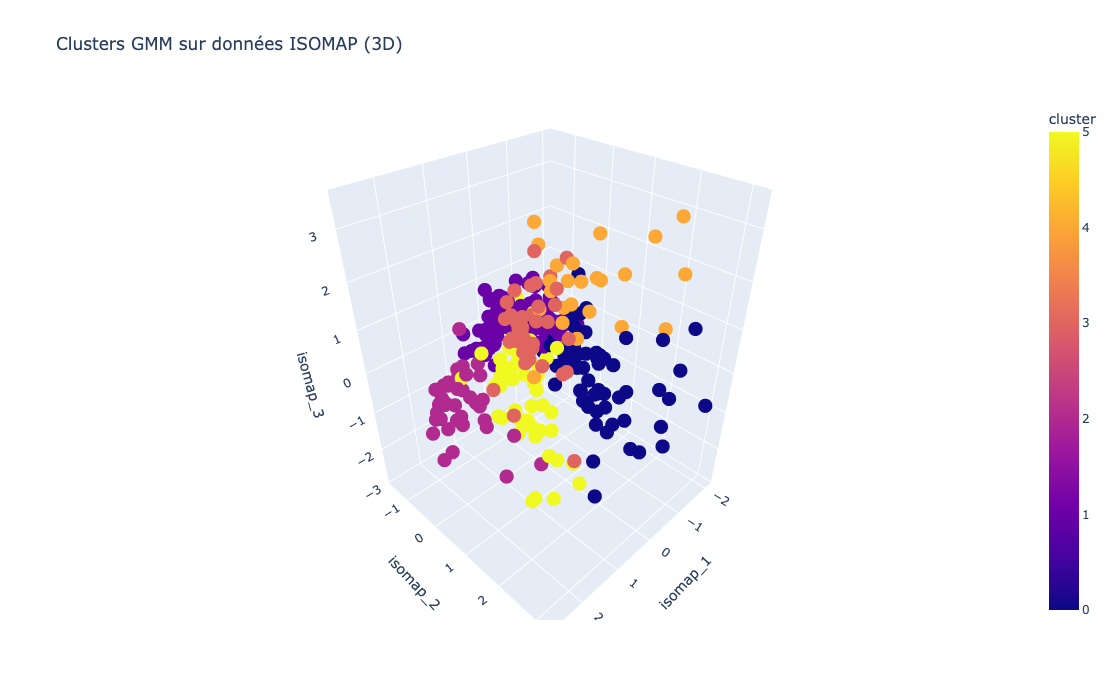

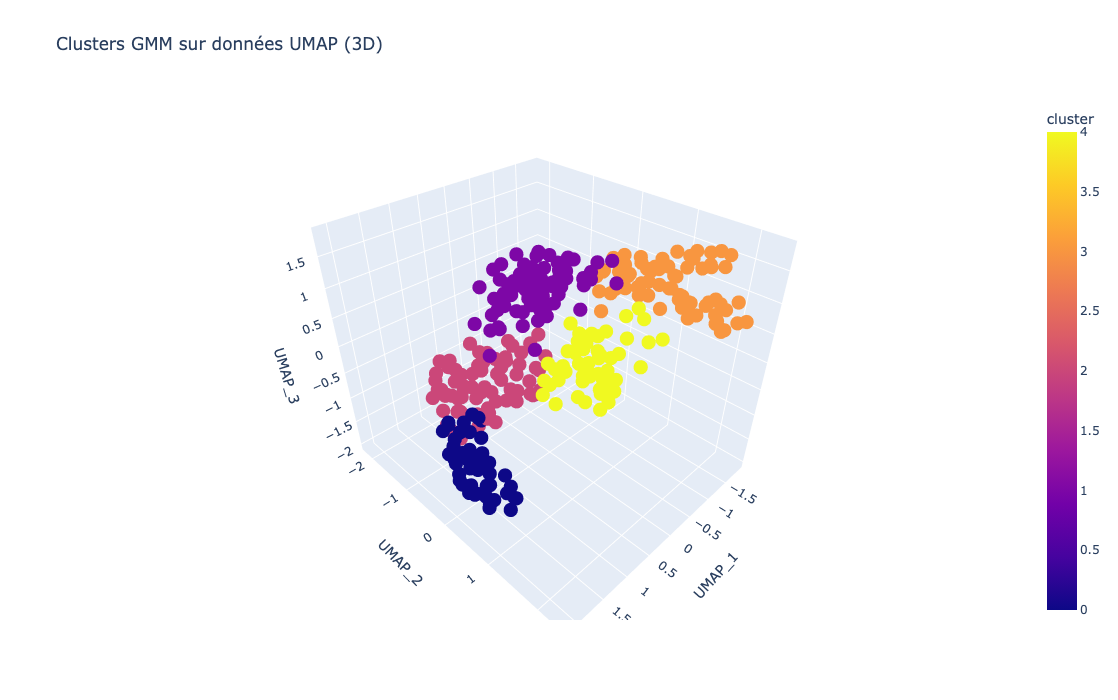

In [45]:
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X,
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters GMM sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

def print_results_3d(X, column1, column2, column3, data_name):
    fig = px.scatter_3d(
        X,
        x=column1,
        y=column2,
        z=column3,
        color='cluster',
        hover_data=['player_name', 'positions'],  # info au survol
        title=f"Clusters GMM sur données {data_name} (3D)",
        width=900,
        height=700,
        color_discrete_sequence=None
    )
    fig.show()

"""
print("="*60)
print("============RESULTS EN 2D===============")
print("="*60)
print_results(X_gmm_PCA_best, "PCA_1", "PCA_2", "PCA")
print_results(X_gmm_tSNE_best, "tsne_1", "tsne_2", "t-SNE")
print_results(X_gmm_ISOMAP_best, "isomap_1", "isomap_2", "ISOMAP")
print_results(X_gmm_UMAP_best, "UMAP_1", "UMAP_2", "UMAP")
"""

print("="*60)
print("============RESULTS EN 3D===============")
print("="*60)
print_results_3d(X_gmm_PCA_best, "PCA_1", "PCA_2", "PCA_3", "PCA")
print_results_3d(X_gmm_tSNE_best, "tsne_1", "tsne_2", "tsne_3", "t-SNE")
print_results_3d(X_gmm_ISOMAP_best, "isomap_1", "isomap_2", "isomap_3", "ISOMAP")
print_results_3d(X_gmm_UMAP_best, "UMAP_1", "UMAP_2", "UMAP_3", "UMAP")